In [1]:
from kan import KAN

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Subset, DataLoader, random_split

from sklearn.model_selection import KFold
from sklearn.metrics import *

In [2]:
dataset_path = 'output_folder'

In [3]:
transform = transforms.Compose(
    [transforms.Resize(size = (220,220)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
dataset = datasets.ImageFolder(dataset_path, transform = transform)

In [5]:
print("Informações sobre o Dataset: \n\n", dataset)
print("\nRótulos: ", dataset.class_to_idx)

Informações sobre o Dataset: 

 Dataset ImageFolder
    Number of datapoints: 24
    Root location: output_folder
    StandardTransform
Transform: Compose(
               Resize(size=(220, 220), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

Rótulos:  {'Inliers': 0, 'Outliers': 1}


In [6]:
model = KAN(width=[220*220*3, 100, 2], grid=3, k=3, base_fun=torch.nn.ReLU())

checkpoint directory created: ./model
saving model version 0.0


In [7]:
num_epoch = 50
learning_rate = 0.001
k = 5

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
kf = KFold(n_splits=k, shuffle=False)

In [30]:
train_array = []
test_array = []

train_losses = []
train_acc = []

rot_array = []
predt_array = []

results = {}

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k}')

    train_array.append(train_idx)
    test_array.append(test_idx)

    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)

    trainloader = DataLoader(train_subset, batch_size=4, shuffle=True)
    testloader = DataLoader(test_subset, batch_size=4, shuffle=True)

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            inputs = inputs.view(-1, 220*220*3)
    
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(trainloader)
        train_losses.append(train_loss)

        _, predicted = torch.max(outputs.data, 1)
        
        acc_treino = accuracy_score(labels, predicted)
        train_acc.append(acc_treino)

        print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f} - Acurácia: {acc_treino:.4f}")

    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(-1, 220*220*3)
        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            rot_array.extend(labels)
            predt_array.extend(predicted)
    
    acc_teste = accuracy_score(labels, predicted)
    print(f'Acc para o Fold {fold+1}: {acc_teste:.4f}')
    results[fold] = acc_teste

    print("!!!Teste finalizado!!!")

print(f'\nResultados K-Fold: {results}')
print(f'Média Acc: {sum(results.values()) / k}')

Fold 1/5
Época 1/50 - Perda no treinamento: 26.819046 - Acurácia: 1.0000
Época 2/50 - Perda no treinamento: 15.766856 - Acurácia: 1.0000
Época 3/50 - Perda no treinamento: 9.378287 - Acurácia: 0.6667
Época 4/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 5/50 - Perda no treinamento: 2.945655 - Acurácia: 1.0000
Época 6/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 7/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 8/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 9/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 10/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 11/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 12/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 13/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 14/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 15/50 - Perda no treinamento: 0.000000 - Acurácia: 1.0000
Época 16/50 - Perda no treinamento: 0.

In [31]:
train_array

[array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23]),
 array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 15, 16, 17, 18, 19, 20, 21,
        22, 23]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 20, 21,
        22, 23]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19])]

In [32]:
test_array

[array([0, 1, 2, 3, 4]),
 array([5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14]),
 array([15, 16, 17, 18, 19]),
 array([20, 21, 22, 23])]

Text(0.5, 0.98, 'Treinamento kfold 1')

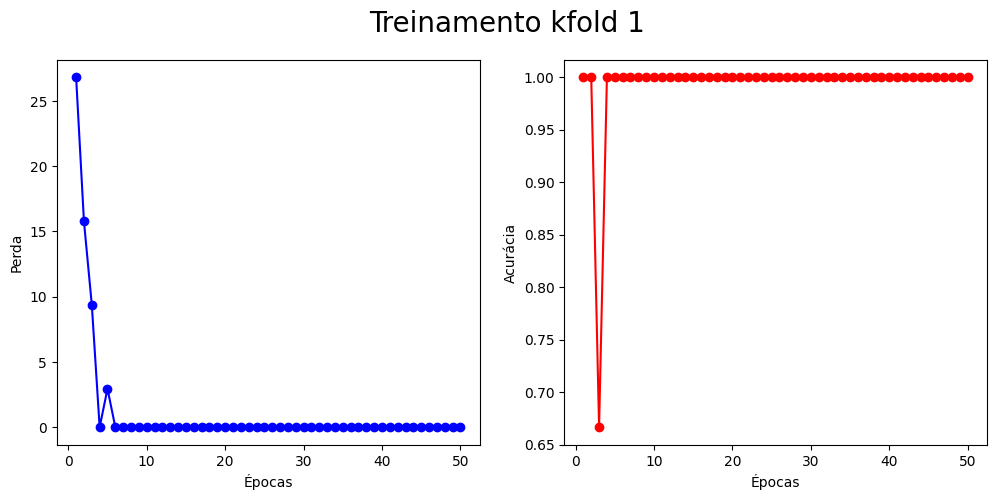

In [35]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[:50], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc[:50], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento kfold 1", fontsize = 20)

Text(0.5, 0.98, 'Treinamento kfold 2')

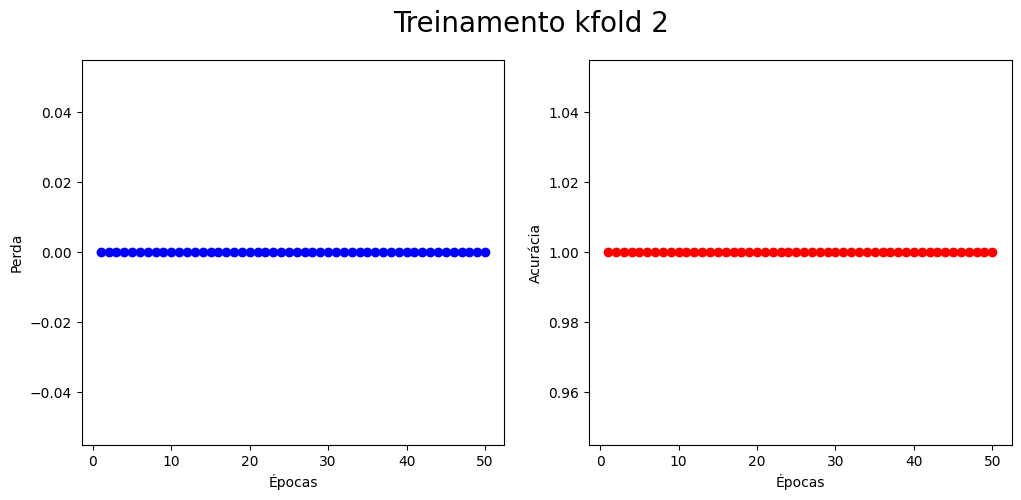

In [36]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[50:100], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc[50:100], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento kfold 2", fontsize = 20)

Text(0.5, 0.98, 'Treinamento kfold 3')

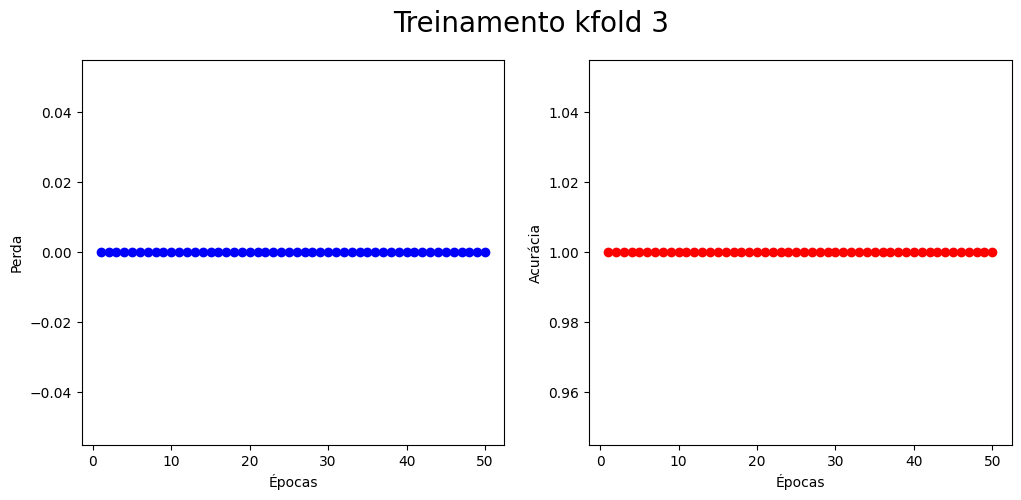

In [37]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[100:150], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc[100:150], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento kfold 3", fontsize = 20)

Text(0.5, 0.98, 'Treinamento kfold 4')

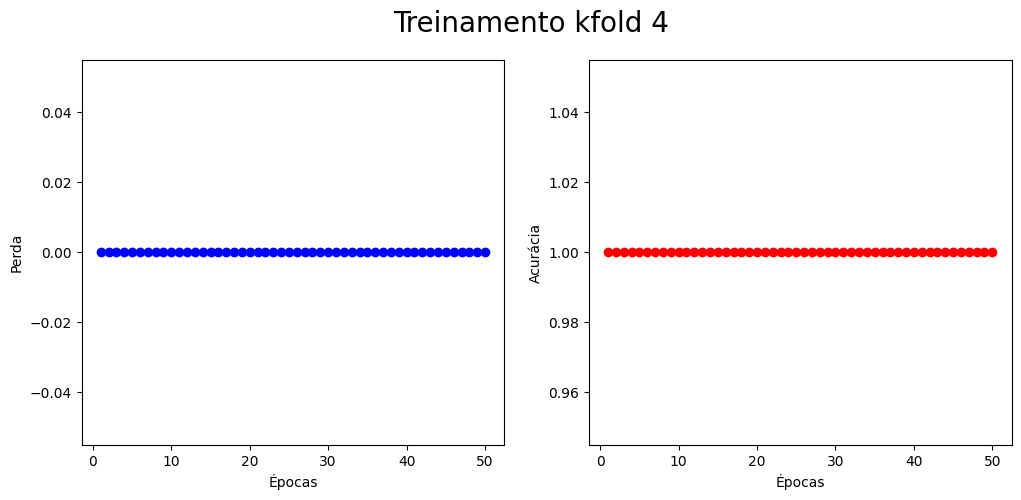

In [38]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[150:200], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc[150:200], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento kfold 4", fontsize = 20)

Text(0.5, 0.98, 'Treinamento kfold 5')

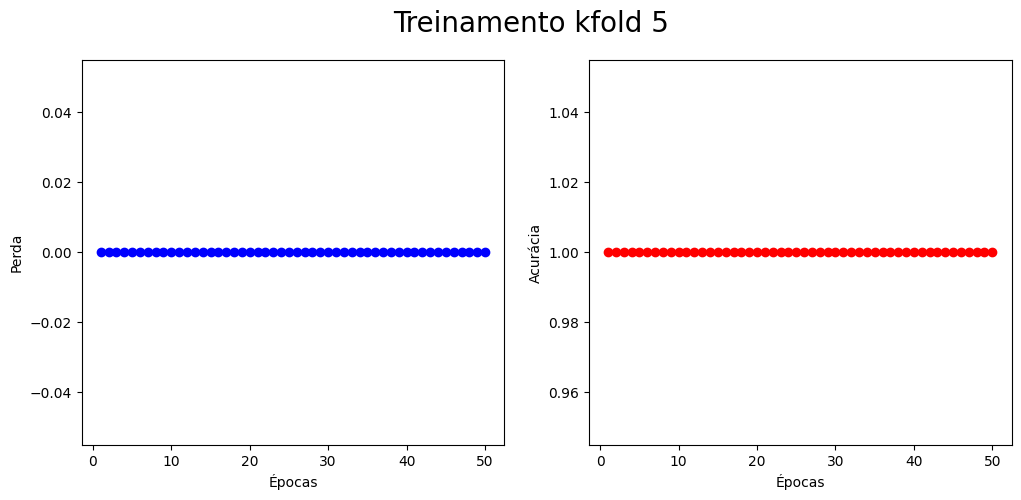

In [39]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[200:250], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc[200:250], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento kfold 5", fontsize = 20)

C:\Users\Aleder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

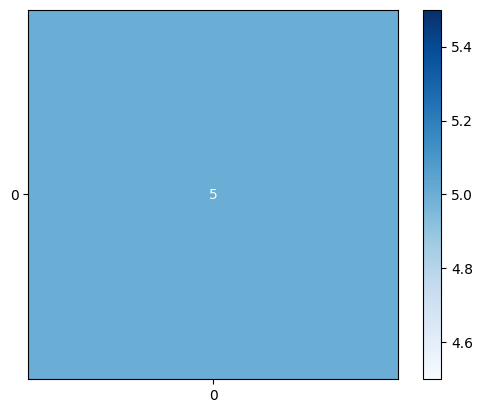

In [40]:
cm = confusion_matrix(rot_array[:5], predt_array[:5])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.title('Teste kfold 1')
plt.show()

In [41]:
acc = accuracy_score(rot_array[:5], predt_array[:5])
print(f"Teste Acurácia kfold 1: {acc * 100 :.2f}%")

Teste Acurácia kfold 1: 100.00%


In [42]:
precision = precision_score(rot_array[:5], predt_array[:5], average='weighted')
print(f"Teste Precisão kfold 1: {precision * 100 :.2f}%")

Teste Precisão kfold 1: 100.00%


In [43]:
recall = recall_score(rot_array[:5], predt_array[:5], average='weighted')
print(f"Teste Recall kfold 1: {recall * 100 :.2f}%")

Teste Recall kfold 1: 100.00%


In [44]:
f1 = f1_score(rot_array[:5], predt_array[:5], average='weighted')
print(f"Teste F1 Score kfold 1: {f1 * 100 :.2f}%")

Teste F1 Score kfold 1: 100.00%


C:\Users\Aleder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

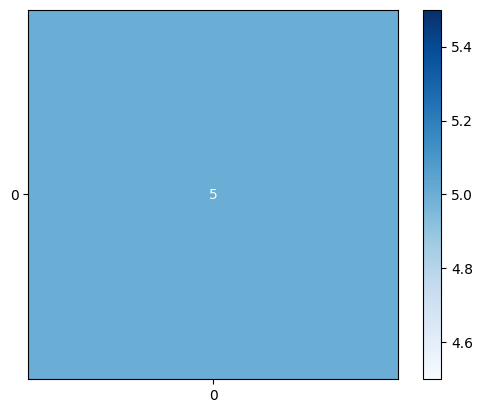

In [45]:
cm = confusion_matrix(rot_array[5:10], predt_array[5:10])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.title('Teste kfold 2')
plt.show()

In [46]:
acc = accuracy_score(rot_array[5:10], predt_array[5:10])
print(f"Teste Acurácia kfold 2: {acc * 100 :.2f}%")

Teste Acurácia kfold 2: 100.00%


In [47]:
precision = precision_score(rot_array[5:10], predt_array[5:10], average='weighted')
print(f"Teste Precisão kfold 2: {precision * 100 :.2f}%")

Teste Precisão kfold 2: 100.00%


In [48]:
recall = recall_score(rot_array[5:10], predt_array[5:10], average='weighted')
print(f"Teste Recall kfold 2: {recall * 100 :.2f}%")

Teste Recall kfold 2: 100.00%


In [49]:
f1 = f1_score(rot_array[5:10], predt_array[5:10], average='weighted')
print(f"Teste F1 Score kfold 2: {f1 * 100 :.2f}%")

Teste F1 Score kfold 2: 100.00%


C:\Users\Aleder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

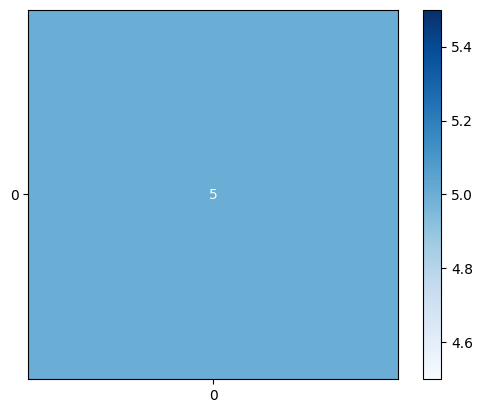

In [50]:
cm = confusion_matrix(rot_array[10:15], predt_array[10:15])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.title('Teste kfold 3')
plt.show()

In [51]:
acc = accuracy_score(rot_array[10:15], predt_array[10:15])
print(f"Teste Acurácia kfold 3: {acc * 100 :.2f}%")

Teste Acurácia kfold 3: 100.00%


In [52]:
precision = precision_score(rot_array[10:15], predt_array[10:15], average='weighted')
print(f"Teste Precisão kfold 3: {precision * 100 :.2f}%")

Teste Precisão kfold 3: 100.00%


In [53]:
recall = recall_score(rot_array[10:15], predt_array[10:15], average='weighted')
print(f"Teste Recall kfold 3: {recall * 100 :.2f}%")

Teste Recall kfold 3: 100.00%


In [54]:
f1 = f1_score(rot_array[10:15], predt_array[10:15], average='weighted')
print(f"Teste F1 Score kfold 3: {f1 * 100 :.2f}%")

Teste F1 Score kfold 3: 100.00%


C:\Users\Aleder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

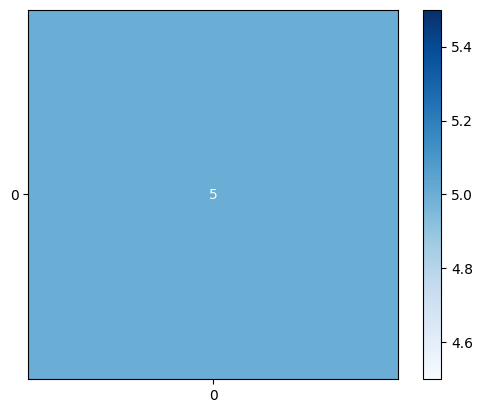

In [55]:
cm = confusion_matrix(rot_array[15:20], predt_array[15:20])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.title('Teste kfold 4')
plt.show()

In [56]:
acc = accuracy_score(rot_array[15:20], predt_array[15:20])
print(f"Teste Acurácia kfold 4: {acc * 100 :.2f}%")

Teste Acurácia kfold 4: 100.00%


In [57]:
precision = precision_score(rot_array[15:20], predt_array[15:20], average='weighted')
print(f"Teste Precisão kfold 4: {precision * 100 :.2f}%")

Teste Precisão kfold 4: 100.00%


In [58]:
recall = recall_score(rot_array[15:20], predt_array[15:20], average='weighted')
print(f"Teste Recall kfold 4: {recall * 100 :.2f}%")

Teste Recall kfold 4: 100.00%


In [59]:
f1 = f1_score(rot_array[15:20], predt_array[15:20], average='weighted')
print(f"Teste F1 Score kfold 4: {f1 * 100 :.2f}%")

Teste F1 Score kfold 4: 100.00%


C:\Users\Aleder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

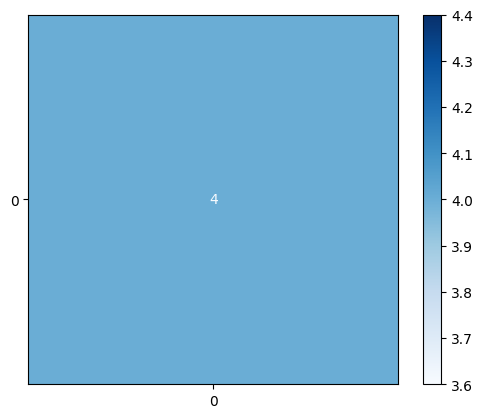

In [60]:
cm = confusion_matrix(rot_array[20:24], predt_array[20:24])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.title('Teste kfold 5')
plt.show()

In [61]:
acc = accuracy_score(rot_array[20:24], predt_array[20:24])
print(f"Teste Acurácia kfold 5: {acc * 100 :.2f}%")

Teste Acurácia kfold 5: 100.00%


In [62]:
precision = precision_score(rot_array[20:24], predt_array[20:24], average='weighted')
print(f"Teste Precisão kfold 5: {precision * 100 :.2f}%")

Teste Precisão kfold 5: 100.00%


In [63]:
recall = recall_score(rot_array[20:24], predt_array[20:24], average='weighted')
print(f"Teste Recall kfold 5: {recall * 100 :.2f}%")

Teste Recall kfold 5: 100.00%


In [64]:
f1 = f1_score(rot_array[20:24], predt_array[20:24], average='weighted')
print(f"Teste F1 Score kfold 5: {f1 * 100 :.2f}%")

Teste F1 Score kfold 5: 100.00%
